In [44]:
! pip install -q tensorflow-model-optimization

In [45]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
#possibly worth using the below 
#tf.compat.v1.enable_eager_executionconfig=None, device_policy=None, execution_mode=None)
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
#from keras import backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

#model optimisation api
import tensorflow_model_optimization as tfmot

import tempfile
import os
import zipfile

%load_ext tensorboard

from tabulate import tabulate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))

        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(24, 12))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.title('Mean Squared Error')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [47]:
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [48]:
#generate the train and testing datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df0 = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df1 = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#convert to numpy
x_values = df0.to_numpy()
y_values = df1.to_numpy()

#removing the frequency row - treating these values as labels
x_values = x_values[1::2,:]

val_split = .2

#generate the test/validation split
#x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size = val_split, random_state = 0)#renaimed x_rem and y_rem to x_values and y_values

In [116]:
#create the models
inputs = keras.layers.Input(shape=(44,))


x = Dense(1056, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out
x = Dense(1056, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
x = Dense(1056, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(528, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
predictions = Dense(44, activation='relu')(x)

l_rate = 4 * 1e-5

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.Nadam(learning_rate=l_rate)

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r_squared]) #tf.keras.metrics.MeanAbsoluteError()


model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1056)              47520     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1056)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 1056)              1116192   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1056)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1056)              1116192   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1056)              0   

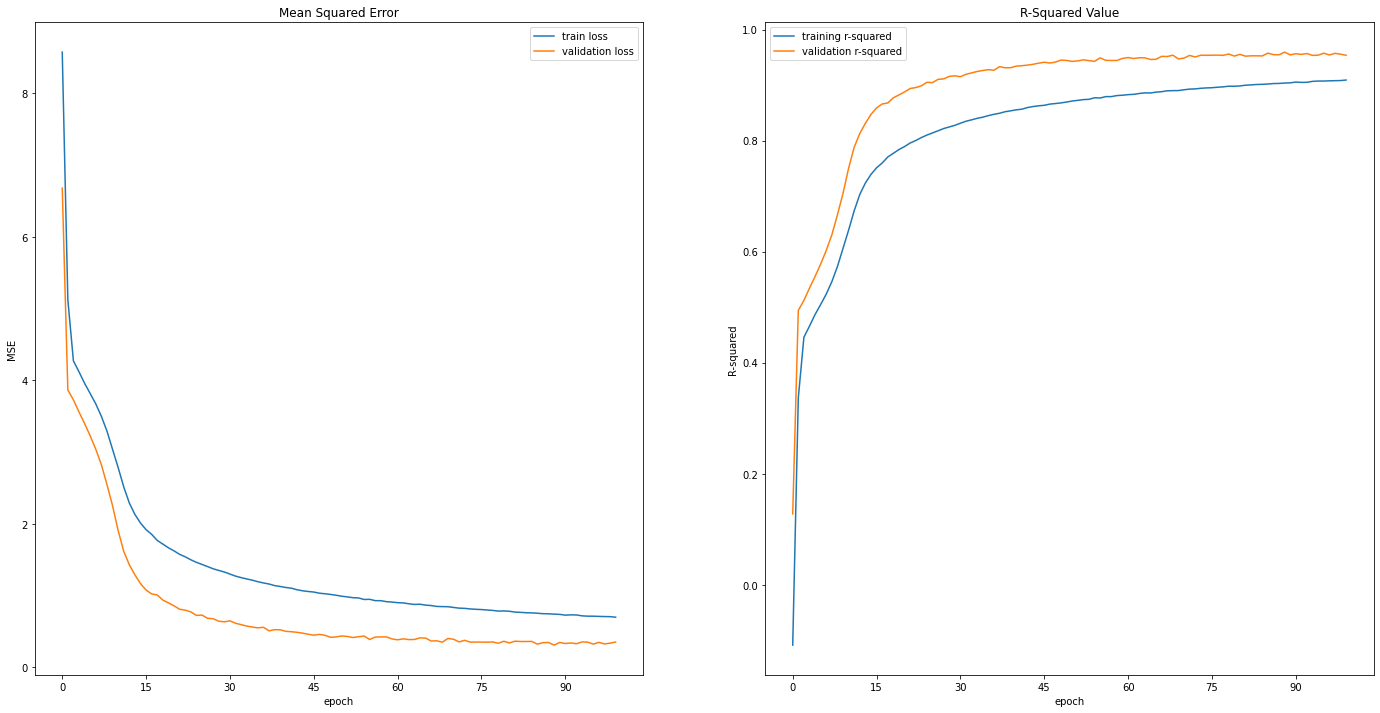

In [117]:
#callback for plotting the model metrics

pltCallBack = PlotLossAccuracy()
#callback for saving the model
checkpoint = ModelCheckpoint(filepath='model_checkpoints/ep_{epoch:02d}_mse_{val_loss:.2f}_r2_{val_r_squared:.2f}.hdf5',
                             monitor='val_loss',
                             verbose=0,
                             save_weights_only=False,
                             save_best_only=True,
                             mode='min',
                             save_freq="epoch")

batchSize = 512

# and train
model.fit(x_train, y_train,
                    batch_size=batchSize, epochs=100, 
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack, checkpoint])

In [95]:
#Quantisation Aware training

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r_squared])

q_aware_model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
quantize_layer (QuantizeLaye (None, 44)                3         
_________________________________________________________________
quant_dense_20 (QuantizeWrap (None, 1056)              47525     
_________________________________________________________________
quant_dropout_16 (QuantizeWr (None, 1056)              1         
_________________________________________________________________
quant_dense_21 (QuantizeWrap (None, 1056)              1116197   
_________________________________________________________________
quant_dropout_17 (QuantizeWr (None, 1056)              1         
_________________________________________________________________
quant_dense_22 (QuantizeWrap (None, 1056)              1116

In [98]:
keras_file = "baseline_model.h5"
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: baseline_model.h5


In [99]:
#set the channel number here
channel = 40

In [100]:
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/x_val.csv'.format(channel))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/y_val.csv'.format(channel))
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )
x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

#removing the frequency row - treating these values as labels
x_test = x_test[1::2,:]

In [118]:
#evaluate the model on the test set
results = model.evaluate(x_test,y_test, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {r2:<.2%}\t(higher is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[1],
                                                                                                    mse = results[0],
                                                                                                    r2 = results[1]))

16/16 [==============================] - 0s 3ms/step - loss: 0.2889 - r_squared: 0.9582
loss		: 0.2889	(lower is better)
r_squared	: 95.82%	(higher is better)


In [119]:
#pruning the model

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

epochs_prune = 400
batch_size = batchSize
#validation_split = val_size # 10% of training set will be used for validation set. 

num_images = x_test.shape[0] * (1 - val_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs_prune


"""          
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.95,
                                                                            begin_step=0,
                                                                            end_step = end_step)}
"""                                                                            

# Define model for pruning - polynomial decay.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.95,
                                                               begin_step=0,
                                                               end_step=end_step)}                                                            
                                                     

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=l_rate / 2),
              loss='mean_squared_error',
              metrics=[r_squared])

model_for_pruning.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
prune_low_magnitude_dense_25 (None, 1056)              93986     
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 1056)              1         
_________________________________________________________________
prune_low_magnitude_dense_26 (None, 1056)              2231330   
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 1056)              1         
_________________________________________________________________
prune_low_magnitude_dense_27 (None, 1056)              2231330   
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 1056)              1   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


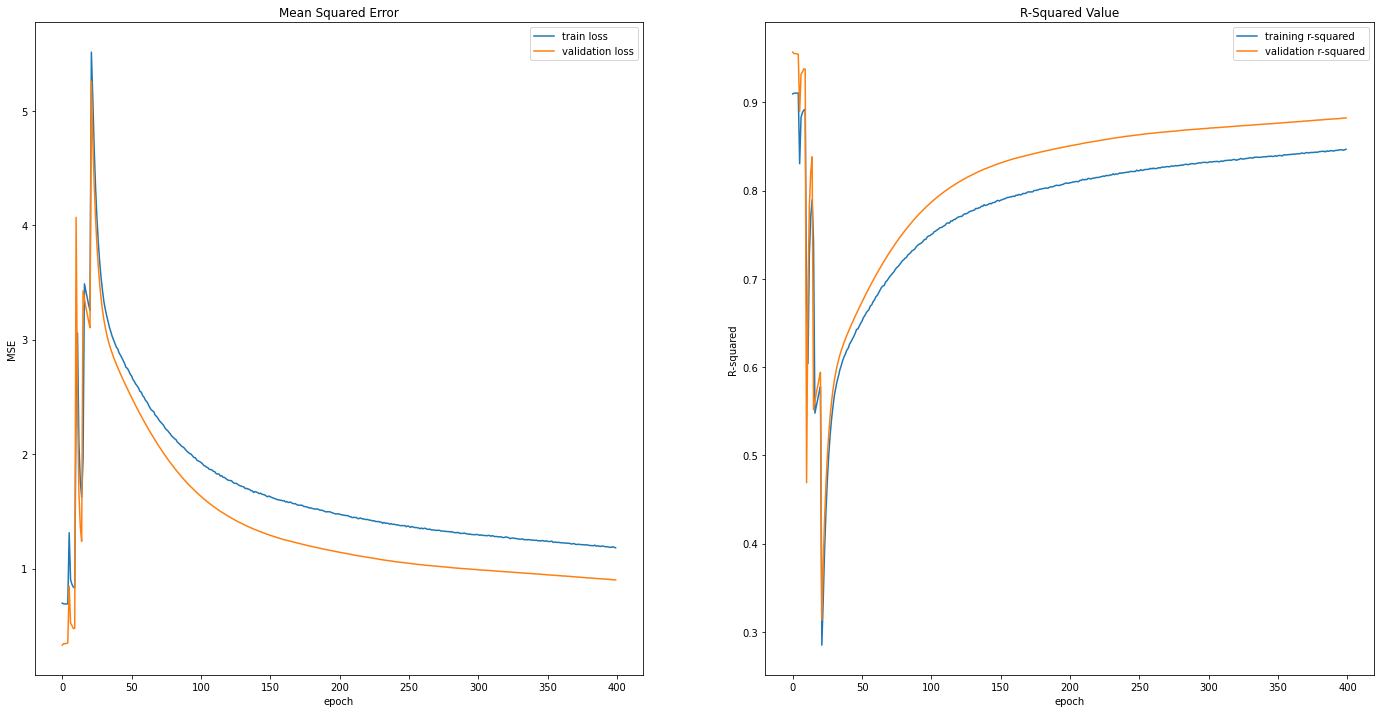

In [120]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  pltCallBack]
  
model_for_pruning.fit(x_train, y_train,
                    batch_size=batchSize,
                    verbose=1,
                    epochs=epochs_prune, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)

In [121]:
#Compare pruned model v unpruned model

results_pruned = model_for_pruning.evaluate(x_test,y_test, verbose=1)
print("Baseline Model:\n{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {r2:<.2%}\t(higher is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[1],
                                                                                                    mse = results[0],
                                                                                                    r2 = results[1]))

print("Pruned Model:\n{namep1}\t\t: {pmse:<.4f}\t(lower is better)\n{namep2}\t: {pr2:<.2%}\t(higher is better)".format(namep1 = model_for_pruning.metrics_names[0],
                                                                                                    namep2 = model_for_pruning.metrics_names[1],
                                                                                                    pmse = results_pruned[0],
                                                                                                    pr2 = results_pruned[1]))

16/16 [==============================] - 0s 3ms/step - loss: 0.9081 - r_squared: 0.8686
Baseline Model:
loss		: 0.2889	(lower is better)
r_squared	: 95.82%	(higher is better)
Pruned Model:
loss		: 0.9081	(lower is better)
r_squared	: 86.86%	(higher is better)


In [122]:
headings = ["Layer Name", "Total Parameters", "% Zero"]
format_row = "{:<50}" * (len(headings) + 1)

values = []

for i, w in enumerate(model_for_pruning.get_weights()):
    if(w.size > 1 and (np.sum(w == 0) != 0)):
      inner_list = []
      inner_list.append("{}".format({model_for_pruning.weights[i].name}))
      inner_list.append("{}".format(w.size))
      inner_list.append("{:.2f}%".format(np.sum(w == 0) / w.size * 100))
      values.append(inner_list)

print (tabulate(values, headings, numalign='left', tablefmt='rst'))

=======================================  ==================  ========
Layer Name                               Total Parameters    % Zero
=======================================  ==================  ========
{'dense_25/kernel:0'}                    46464               95.00%
{'prune_low_magnitude_dense_25/mask:0'}  46464               95.00%
{'dense_26/kernel:0'}                    1115136             95.00%
{'prune_low_magnitude_dense_26/mask:0'}  1115136             95.00%
{'dense_27/kernel:0'}                    1115136             95.00%
{'prune_low_magnitude_dense_27/mask:0'}  1115136             95.00%
{'dense_28/kernel:0'}                    557568              95.00%
{'prune_low_magnitude_dense_28/mask:0'}  557568              95.00%
{'dense_29/kernel:0'}                    23232               95.00%
{'prune_low_magnitude_dense_29/mask:0'}  23232               95.00%
=======================================  ==================  ========


In [ ]:

#docs_infra: no_execute
%tensorboard --logdir={logdir}

In [123]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpzr6e9zfk.h5


In [124]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

"""
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()
"""

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(tflite_quant_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmp_85vm841/assets


INFO:tensorflow:Assets written to: /tmp/tmp_85vm841/assets


Saved pruned TFLite model to: /tmp/tmp8bz_zgje.tflite


In [125]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.  

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [126]:
orig = get_gzipped_model_size(keras_file)
reduced = get_gzipped_model_size(pruned_keras_file)
tf_lite = get_gzipped_model_size(pruned_tflite_file)

print("Size of gzipped baseline Keras model:\t {:,d} bytes".format(orig))
print("Size of gzipped pruned Keras model:\t {:,d} bytes".format(reduced))
print("Pruning Compression: {:.1%}".format(1 - reduced/orig)) 
print("Size of gzipped pruned TFlite model: {:,d} bytes".format(tf_lite))
print("Compression: {:.1%}".format(1 - tf_lite/orig)) 


Size of gzipped baseline Keras model:	 10,593,652 bytes
Size of gzipped pruned Keras model:	 1,562,737 bytes
Pruning Compression: 85.2%
Size of gzipped pruned TFlite model: 371,999 bytes
Compression: 96.5%
